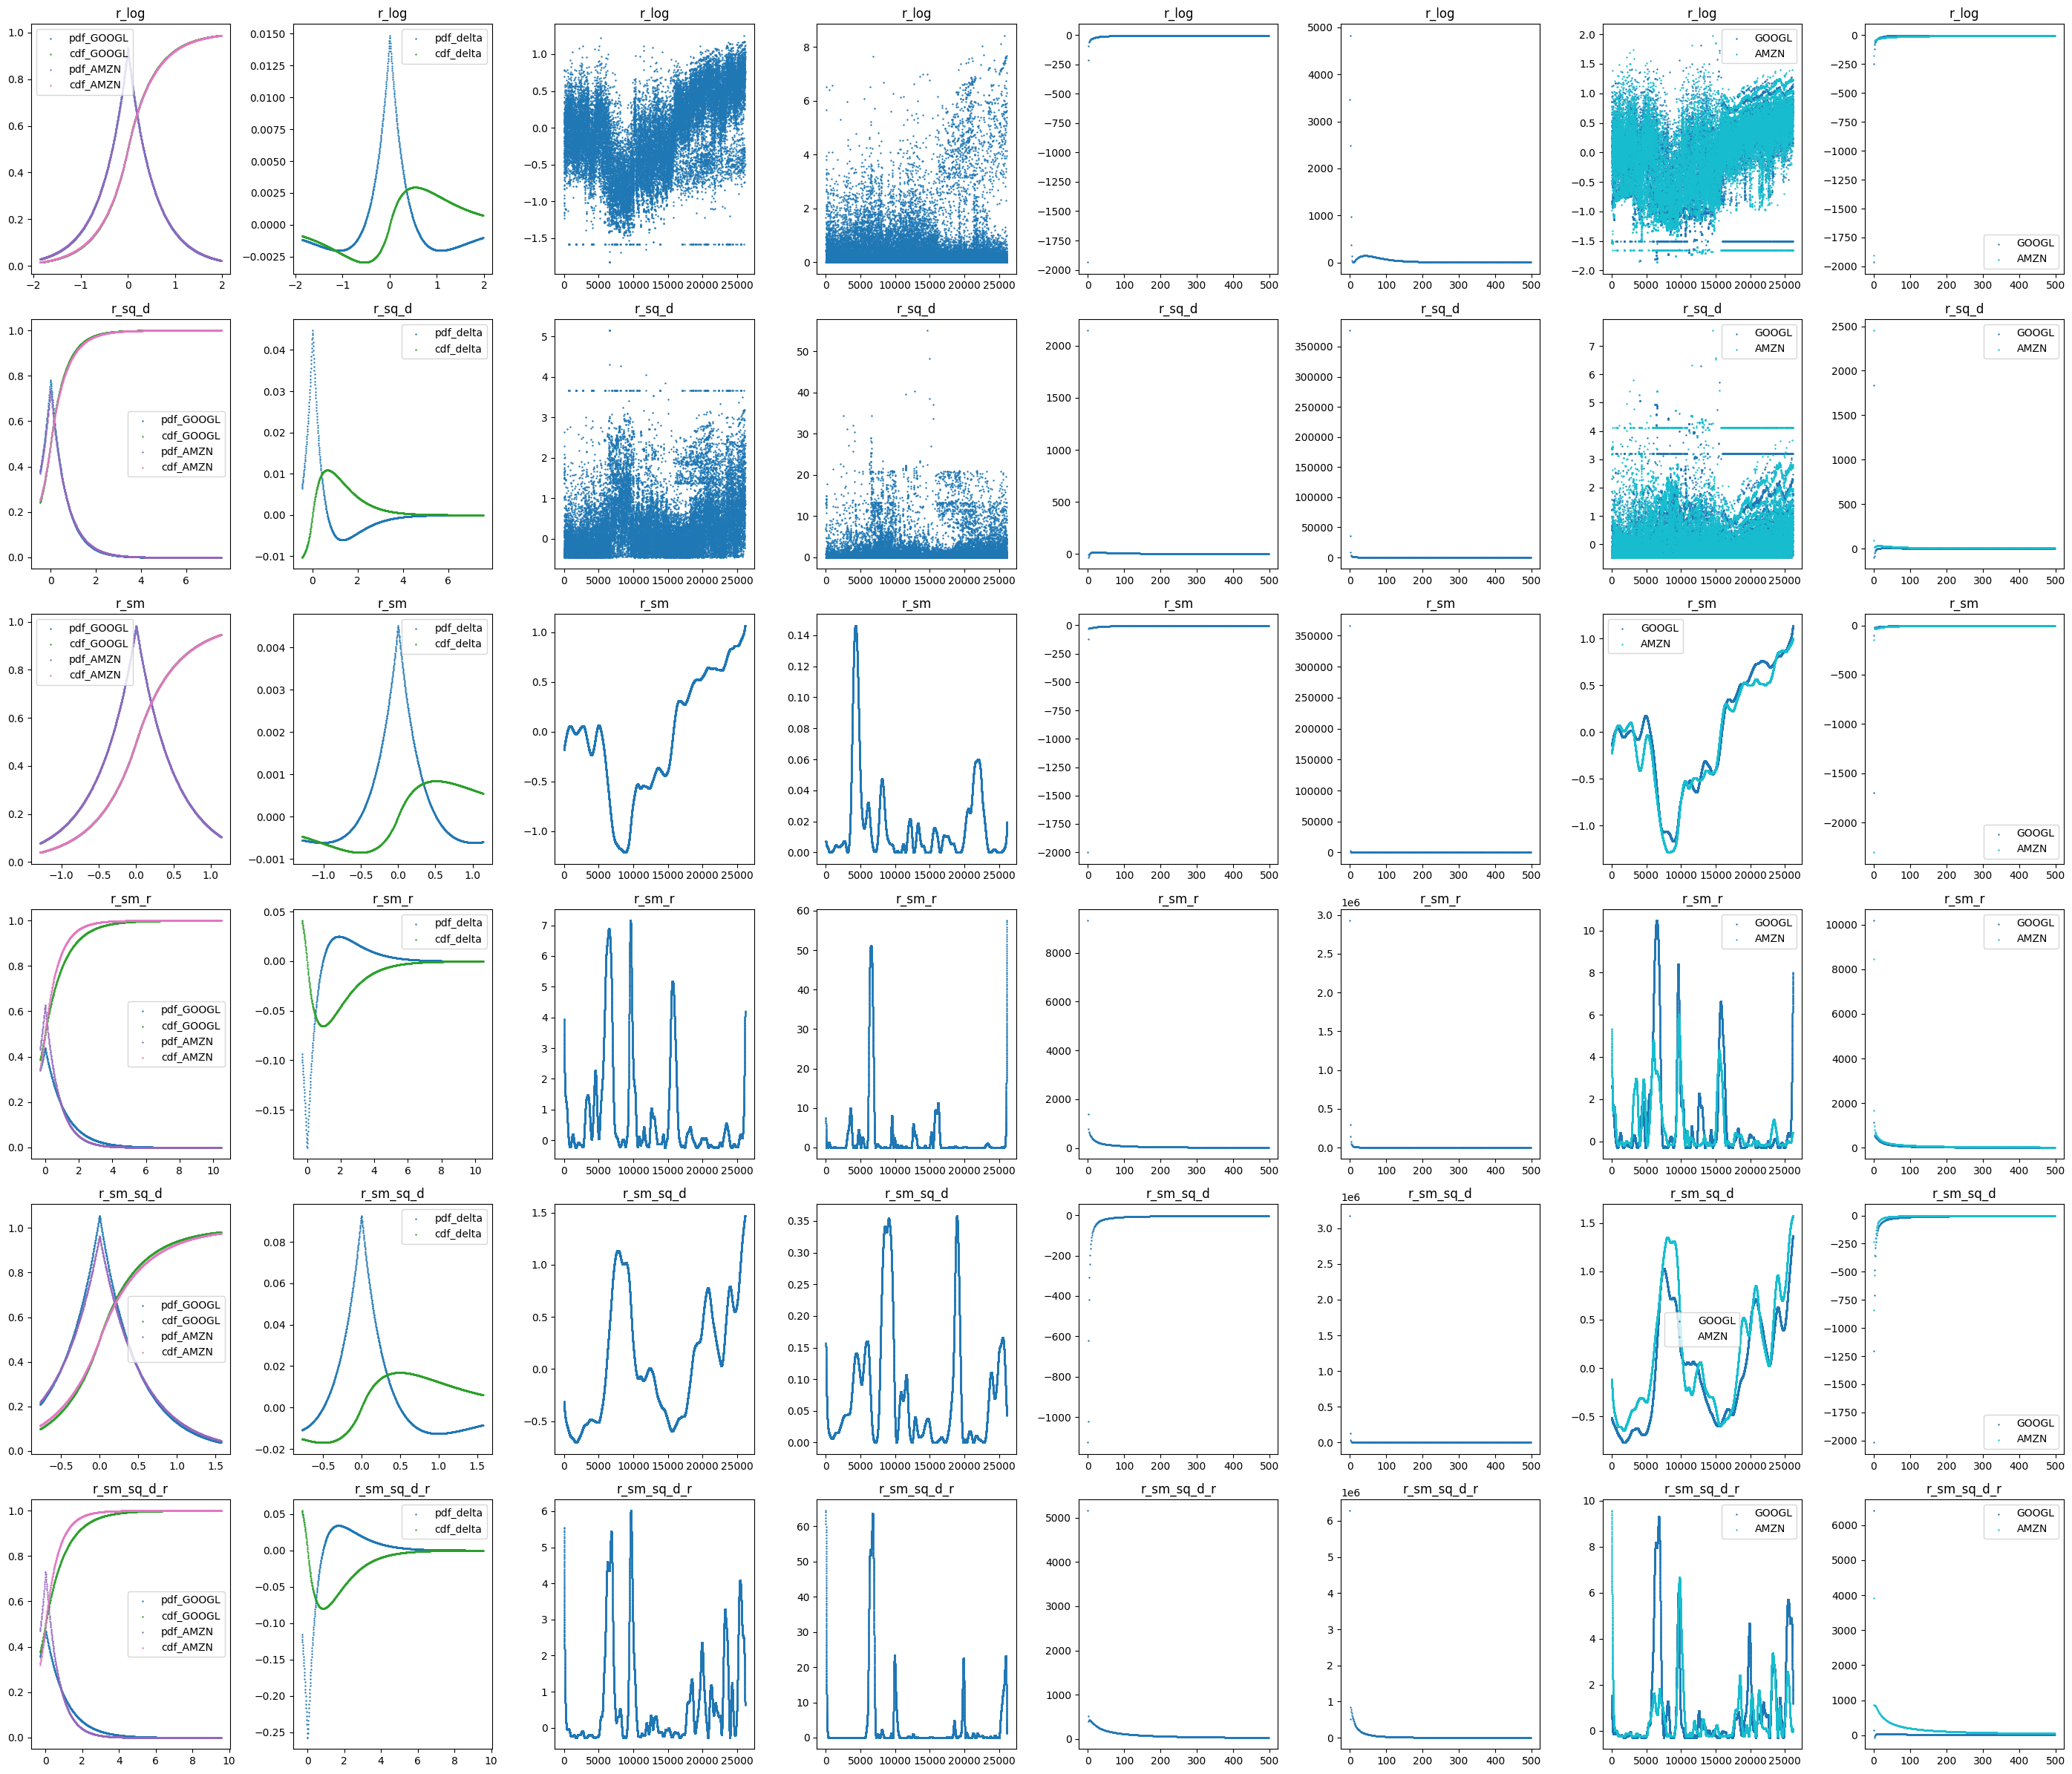

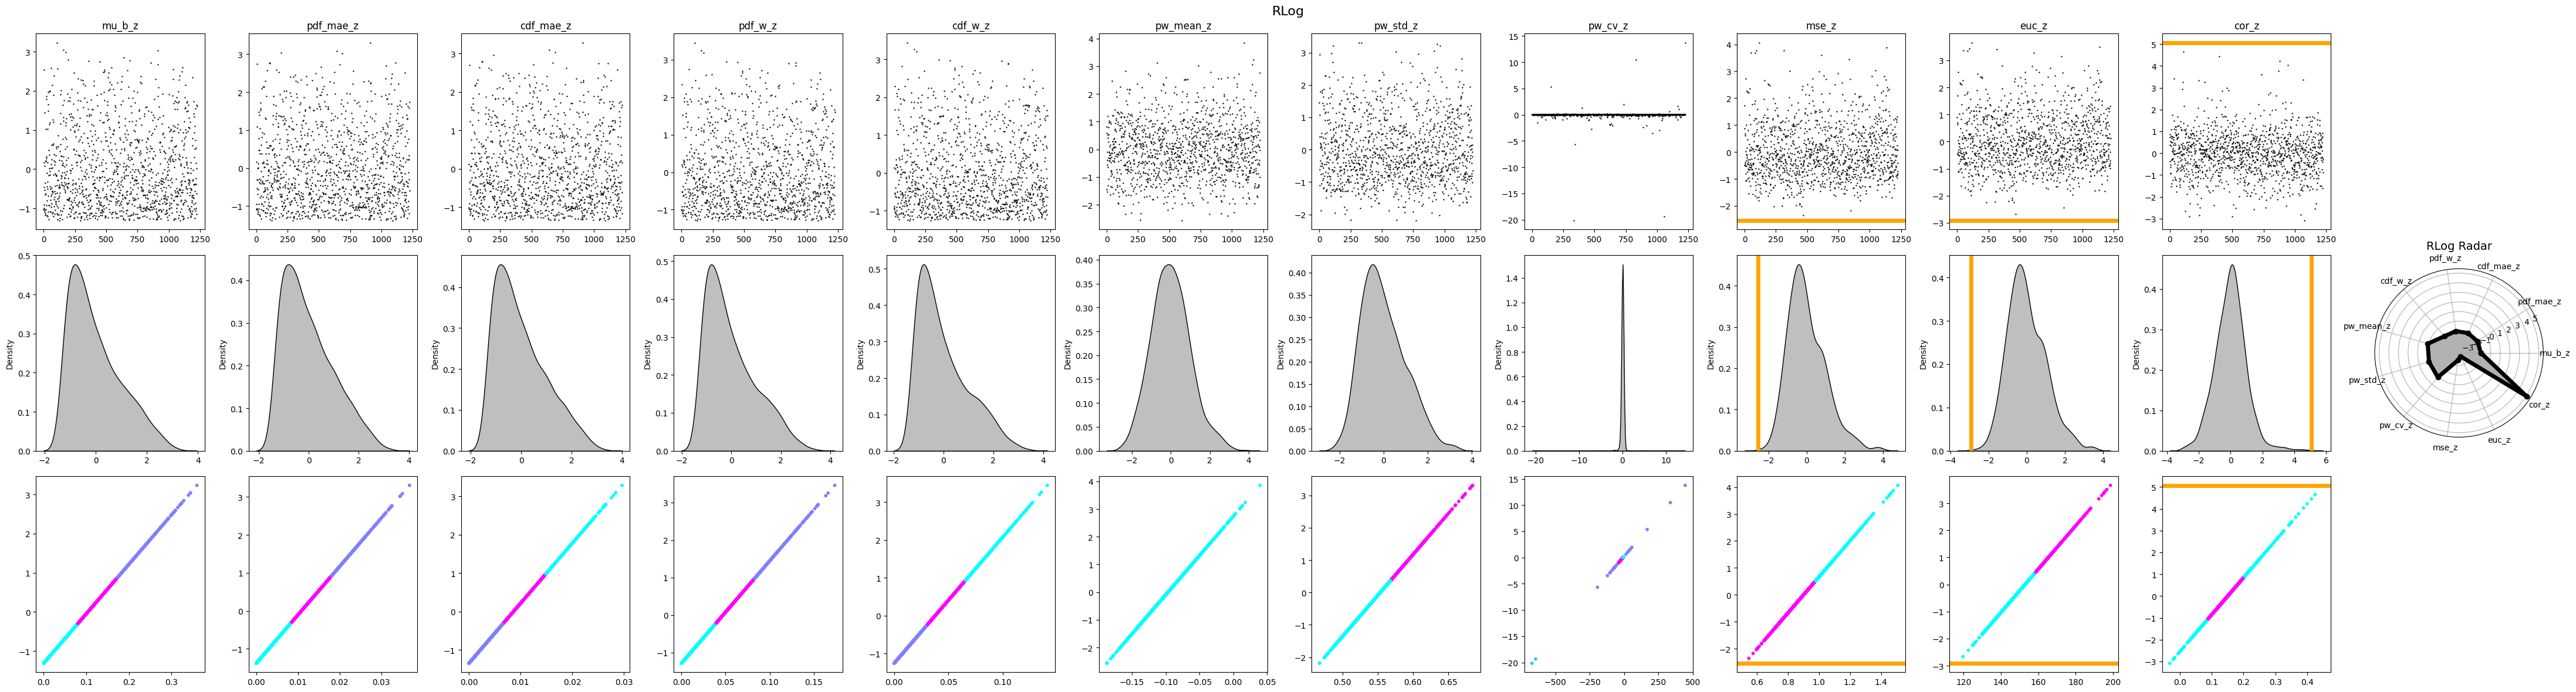

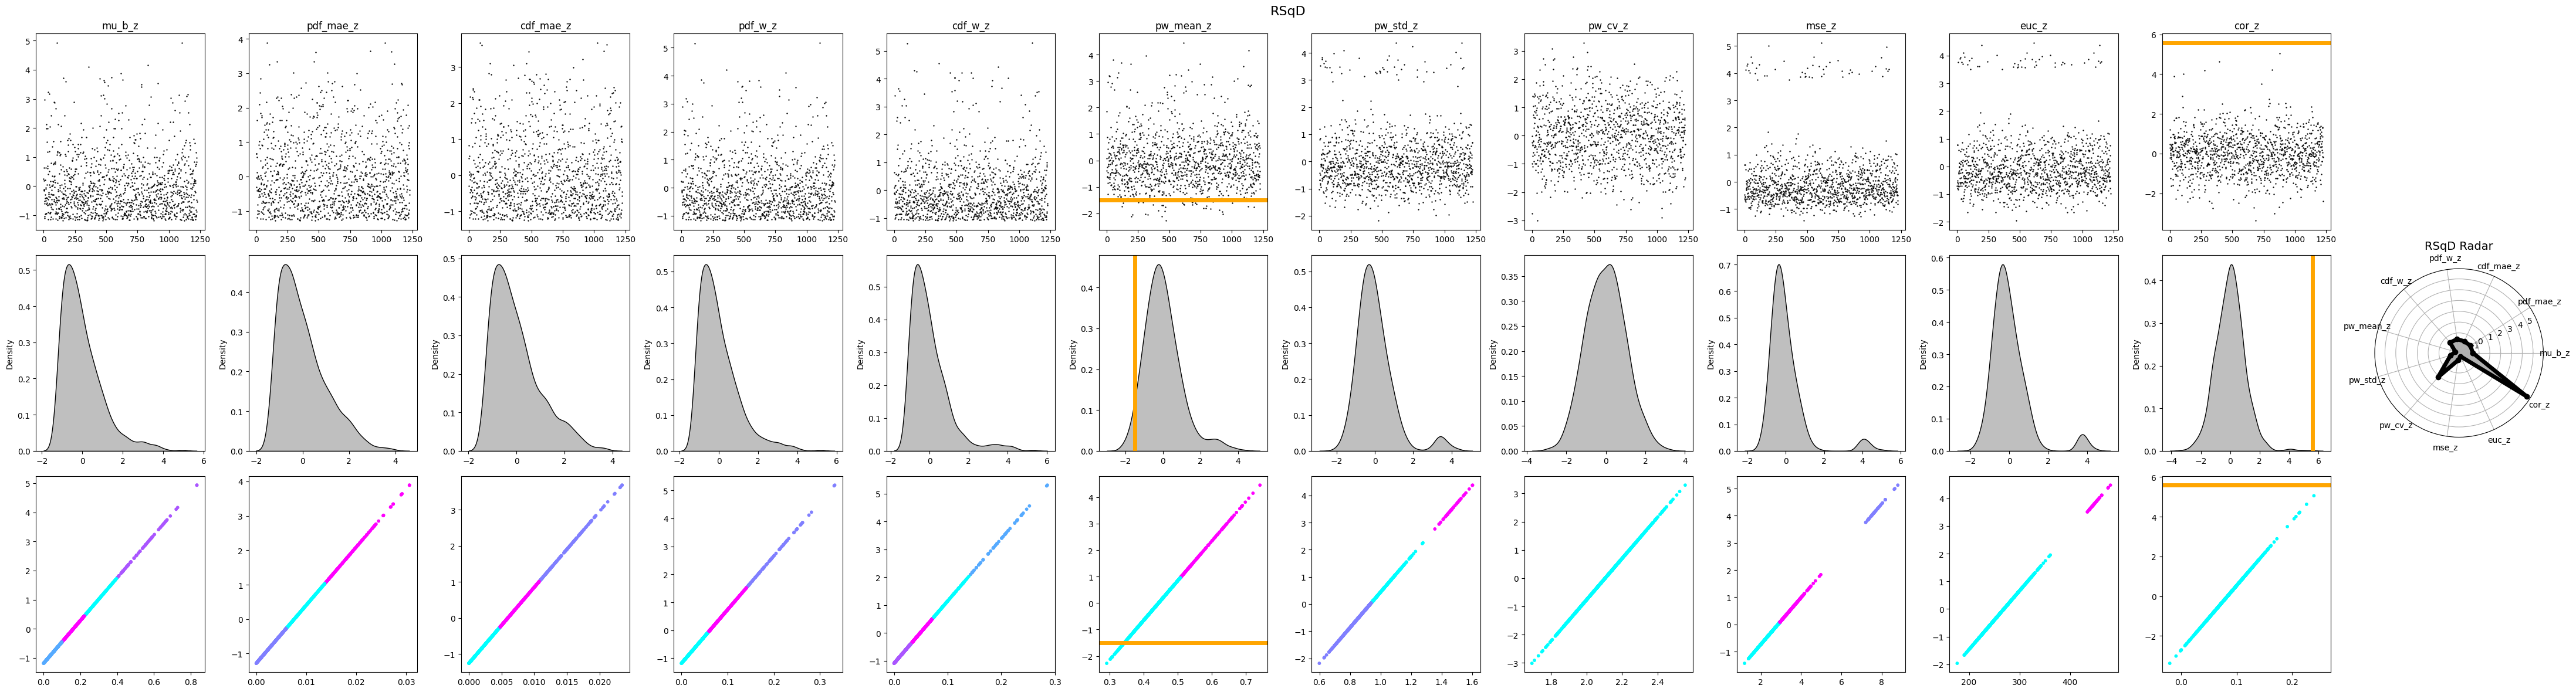

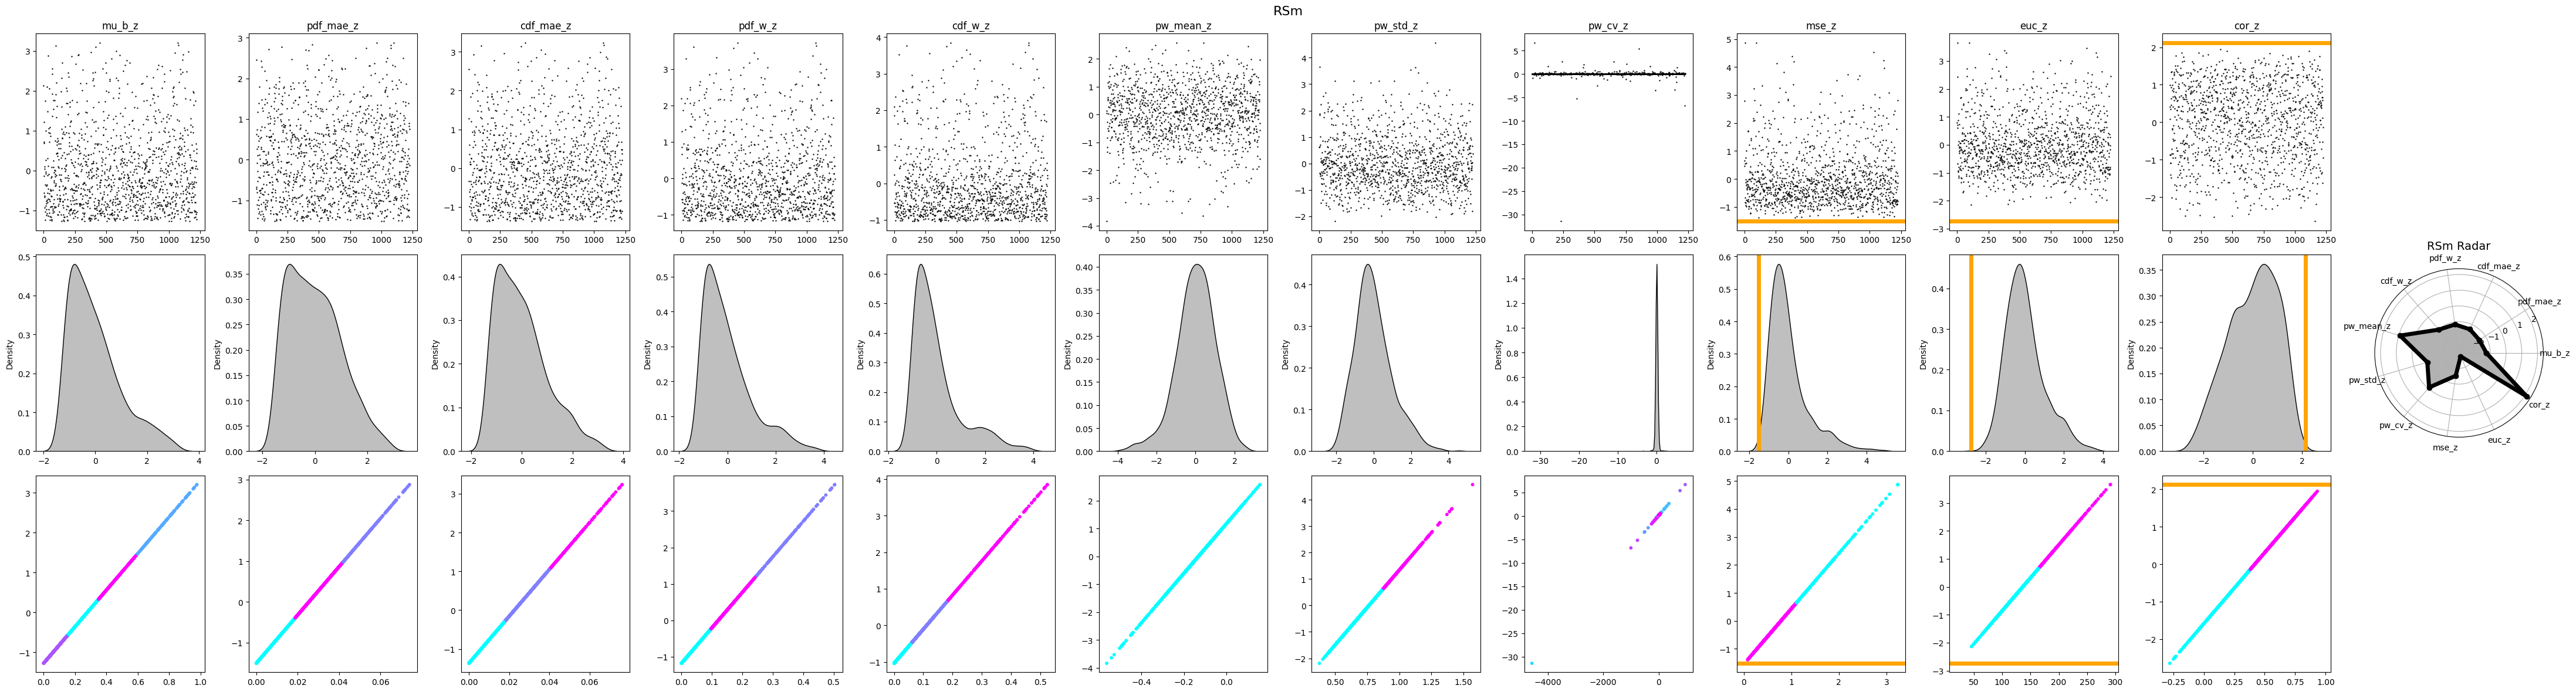

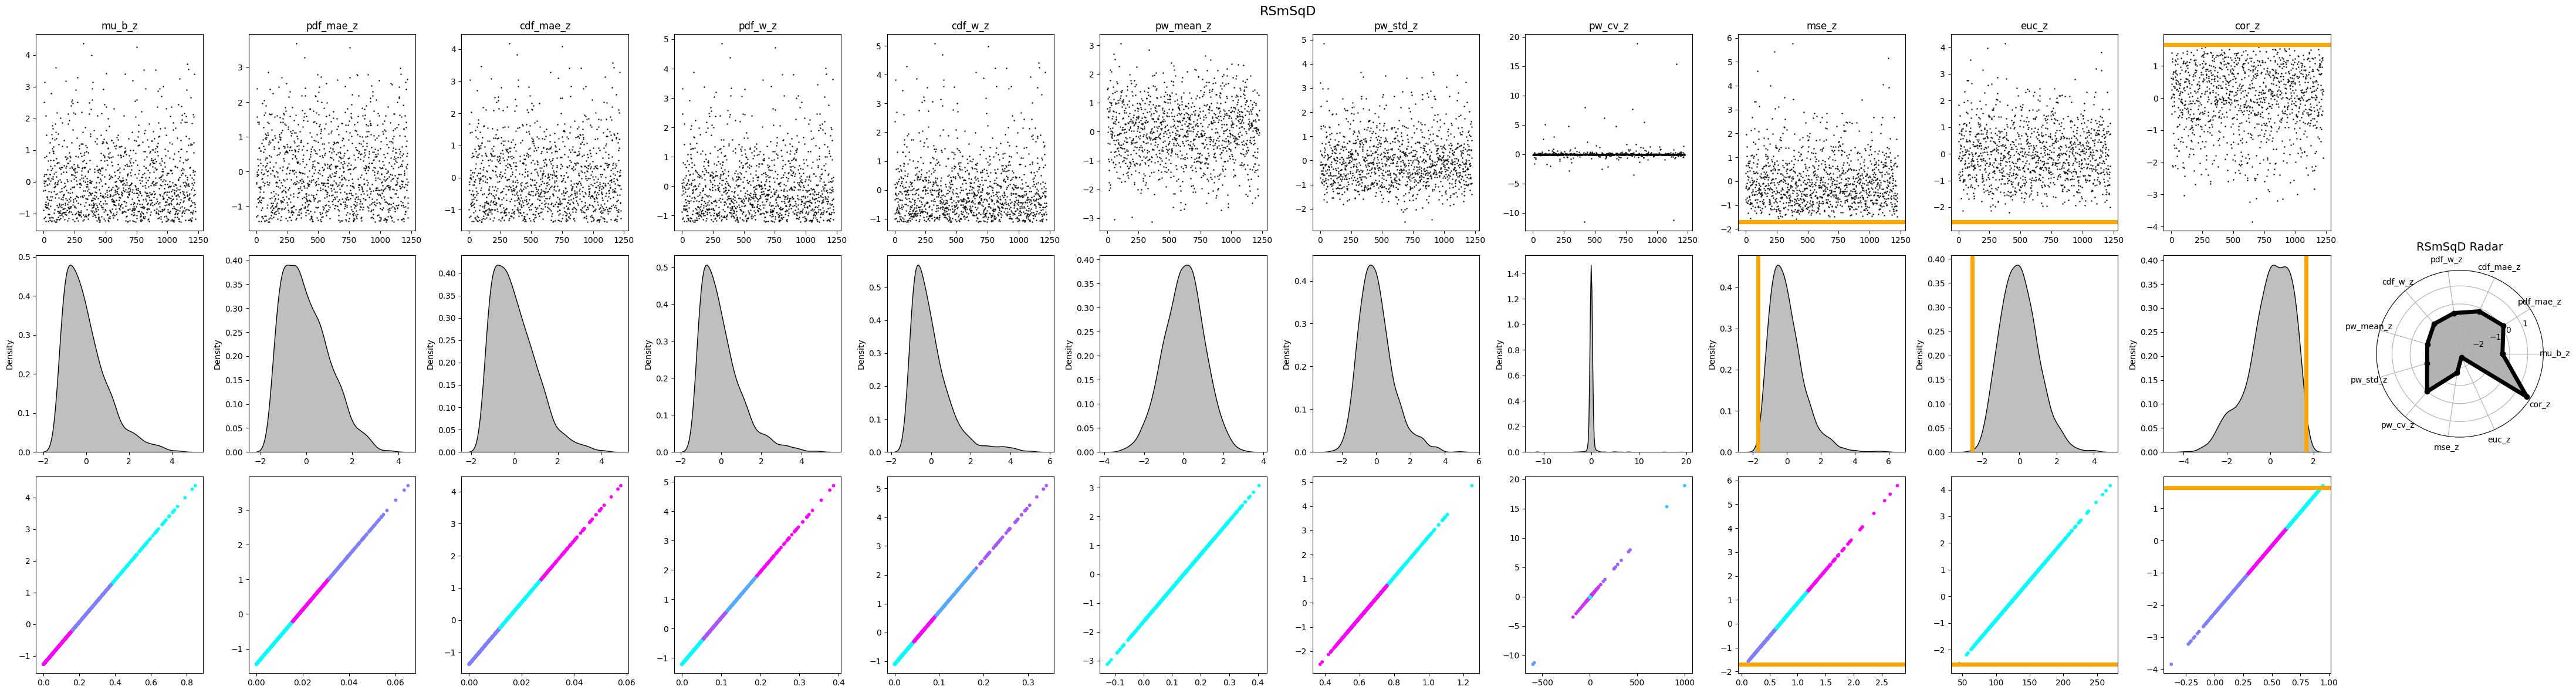

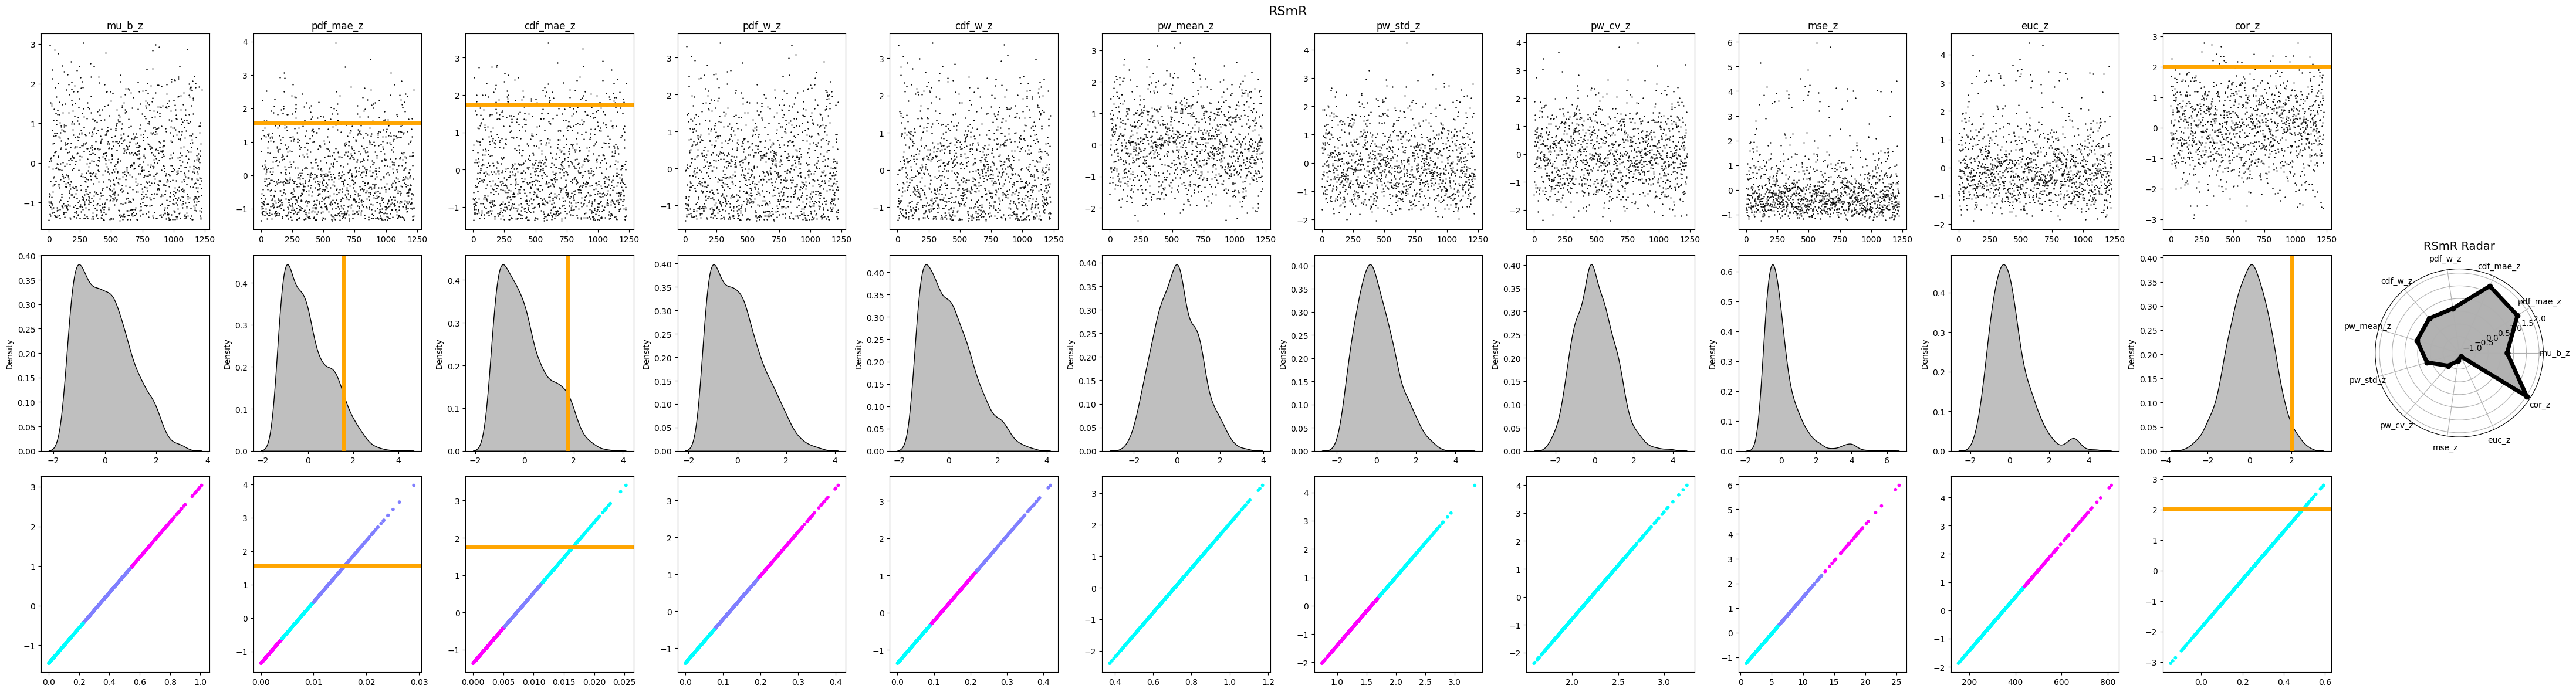

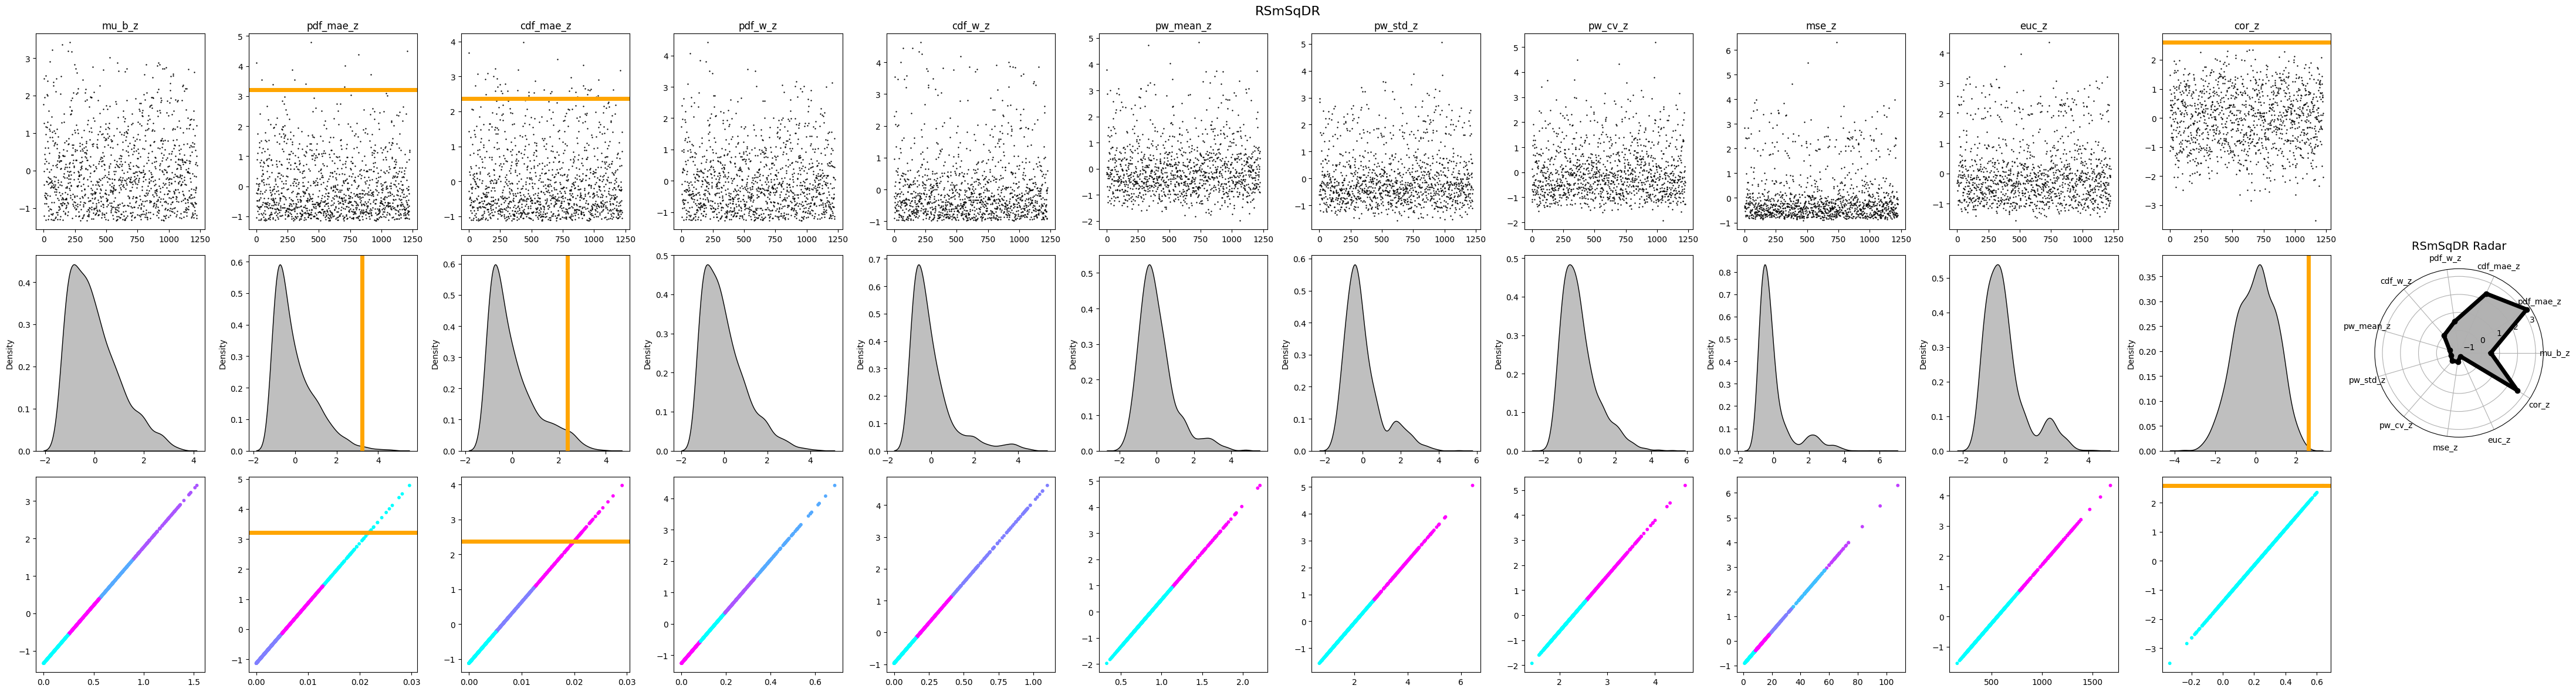

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.mixture import GaussianMixture
import matplotlib.gridspec as gridspec

SYMBOLS = ['GOOGL', 'AMZN']
SYMBOL1, SYMBOL2 = SYMBOLS[0], SYMBOLS[1]
BASE_METRICS = ['r_log', 'r_sq_d', 'r_sm', 'r_sm_r', 'r_sm_sq_d', 'r_sm_sq_d_r']
FIELDS = ["RLog", "RSqD", "RSm", "RSmSqD", "RSmR", "RSmSqDR"]
RAW_START_COL = 3
RAW_END_COL = 14
Z_START_COL = 14
Z_END_COL = 25
METRIC_NAMES = ["mu_b_z", "pdf_mae_z", "cdf_mae_z", "pdf_w_z", "cdf_w_z", 
                "pw_mean_z", "pw_std_z", "pw_cv_z", "mse_z", "euc_z", "cor_z"]

def get_data_dirs(symbols, base_dir='optimal'):
    symbol_dir = '_'.join(symbols)
    return os.path.join(base_dir, symbol_dir)

def load_data(filepath, header=True, names=None):
    return pd.read_csv(filepath, header=0 if header else None, names=names)

def load_metric_data(metric, data_dir):
    df_parent = load_data(os.path.join(data_dir, 'DIST', f'{metric}.csv'))
    df_pw = load_data(os.path.join(data_dir, 'PW', f'{metric}.csv'), header=False)
    df_pw_t = load_data(os.path.join(data_dir, 'PW_T', f'{metric}.csv'), header=False)
    return df_parent, df_pw, df_pw_t

def generate_colors(n, cmap_name='tab10'):
    cmap = plt.get_cmap(cmap_name)
    return cmap(np.linspace(0, 1, n))

def plot_pdf_cdf(ax, df, grid, colors, title):
    for i, col in enumerate([col for col in df.columns if col.startswith('pdf_') or col.startswith('cdf_')]):
        ax.scatter(grid, df[col], label=col, color=colors[i % len(colors)], s=0.5)
    ax.set_title(f'{title}')
    ax.legend()

def plot_diff(ax, df, grid, colors, title):
    for i, col in enumerate(['pdf_delta', 'cdf_delta']):
        if col in df.columns:
            ax.scatter(grid, df[col], label=col, color=colors[i % len(colors)], s=0.5)
    ax.set_title(f'{title}')
    ax.legend()

def plot_time_series(ax, df, colors, title):
    x = range(len(df))
    for i in range(len(df.columns)):
        ax.scatter(x, df.iloc[:, i], color=colors[i % len(colors)], s=0.5)
    ax.set_title(f'{title}')

def plot_all_panels(axs_row, metric, df_parent, df_pw, df_pw_t, grid, colors):
    plot_pdf_cdf(axs_row[0], df_parent.iloc[:, :5], grid, colors, metric)
    plot_diff(axs_row[1], df_parent, grid, colors, metric)
    plot_time_series(axs_row[2], df_pw.iloc[:, [0]], colors, metric)
    plot_time_series(axs_row[3], df_pw.iloc[:, [1]], colors, metric)
    plot_time_series(axs_row[4], df_pw_t.iloc[:, [0]], colors, metric)
    plot_time_series(axs_row[5], df_pw_t.iloc[:, [1]], colors, metric)

def load_symbol_data(symbol, base_dir):
    ext_path = os.path.join(base_dir, f'{symbol}/EXT.csv')
    lap_path = os.path.join(base_dir, f'{symbol}/LAP.csv')
    ext_df = pd.read_csv(ext_path)
    lap_df = pd.read_csv(lap_path)
    return ext_df, lap_df

def plot_ext_lap_column(ax_ext, ax_lap, ext1, ext2, lap1, lap2, metric, symbol1, symbol2, colors):
    for df, color, label in zip([ext1, ext2], colors, [symbol1, symbol2]):
        ax_ext.scatter(df.index, df[metric], color=color, label=f'{label}', s=0.5)
    ax_ext.set_title(f'{metric}')
    ax_ext.legend()

    for df, color, label in zip([lap1, lap2], colors, [symbol1, symbol2]):
        ax_lap.scatter(df.index, df[metric], color=color, label=f'{label}', s=0.5)
    ax_lap.set_title(f'{metric}')
    ax_lap.legend()

def run_script1():
    metric_count = len(BASE_METRICS)
    fig, axs = plt.subplots(metric_count, 8, figsize=(28, 4 * metric_count))
    colors = generate_colors(6)
    extlap_colors = generate_colors(2)

    base_dir_extlap = 'export'
    ext1, lap1 = load_symbol_data(SYMBOL1, base_dir_extlap)
    ext2, lap2 = load_symbol_data(SYMBOL2, base_dir_extlap)

    data_dir = get_data_dirs(SYMBOLS)
    for i, metric in enumerate(BASE_METRICS):
        df_parent, df_pw, df_pw_t = load_metric_data(metric, data_dir)
        grid = df_parent['grid']
        plot_all_panels(axs[i][:6], metric, df_parent, df_pw, df_pw_t, grid, colors)
        plot_ext_lap_column(axs[i][6], axs[i][7], ext1, ext2, lap1, lap2, metric, SYMBOL1, SYMBOL2, extlap_colors)

    plt.tight_layout()
    plt.show()

def extract_raw_and_z(data: np.ndarray):
    raw = [data[:, col].astype(float) for col in range(RAW_START_COL, RAW_END_COL)]
    z = [data[:, col].astype(float) for col in range(Z_START_COL, Z_END_COL)]
    indices = np.arange(len(data))
    return indices, raw, z

def extract_symbol_z_scores(subset: pd.DataFrame, symbol1: str, symbol2: str):
    row = subset[(subset["symbol1"] == symbol1) & (subset["symbol2"] == symbol2)]
    if not row.empty:
        return row.iloc[0, Z_START_COL:Z_END_COL].astype(float).tolist()
    return None

def optimal_gmm_k(data: np.ndarray, max_k: int = 9) -> int:
    bic_scores = [GaussianMixture(n_components=k).fit(data).bic(data) for k in range(1, max_k + 1)]
    return np.argmin(bic_scores) + 1

def fit_gmm(data: np.ndarray) -> GaussianMixture:
    k = optimal_gmm_k(data)
    gmm = GaussianMixture(n_components=k)
    gmm.fit(data)
    return gmm

def plot_metric_grid(fig, gs, indices, raw_values, z_scores, symbol_z_scores):
    for row in range(3):
        for col in range(len(METRIC_NAMES)):
            ax = fig.add_subplot(gs[row, col])
            metric_z = symbol_z_scores[col] if symbol_z_scores is not None else None
            z_data = z_scores[col]
            z_mean = np.mean(z_data)
            z_std = np.std(z_data)
            mark = metric_z is not None and (abs(metric_z - z_mean) > z_std * 1.5)

            if row == 0:
                ax.scatter(indices, z_data, s=0.5, color="black")
                if mark:
                    ax.axhline(metric_z, color="orange", linestyle="-", linewidth=5)
                ax.set_title(METRIC_NAMES[col])

            elif row == 1:
                sns.kdeplot(z_data, ax=ax, fill=True, color="black")
                if mark:
                    ax.axvline(metric_z, color="orange", linestyle="-", linewidth=5)

            elif row == 2:
                features = np.vstack((raw_values[col], z_data)).T
                gmm = fit_gmm(features)
                labels = gmm.predict(features)
                ax.scatter(raw_values[col], z_data, c=labels, cmap='cool', s=10)
                if mark:
                    ax.axhline(metric_z, color="orange", linestyle="-", linewidth=5)

def plot_radar_chart(fig, gs, field_name, symbol_z_scores):
    radar_ax = fig.add_subplot(gs[:, -1], polar=True)
    values = symbol_z_scores + [symbol_z_scores[0]]
    angles = np.linspace(0, 2 * np.pi, len(symbol_z_scores), endpoint=False).tolist()
    angles += [angles[0]]

    radar_ax.plot(angles, values, 'o-', linewidth=5, color="black")
    radar_ax.fill(angles, values, color="black", alpha=0.3)
    radar_ax.set_xticks(np.linspace(0, 2 * np.pi, len(METRIC_NAMES), endpoint=False))
    radar_ax.set_xticklabels(METRIC_NAMES)
    radar_ax.set_title(f"{field_name} Radar", size=14)

def plot_all(field_name, indices, raw_values, z_scores, symbol_z_scores=None):
    num_metrics = len(METRIC_NAMES)
    fig = plt.figure(figsize=(4 * num_metrics, 12))
    gs = gridspec.GridSpec(3, num_metrics + 1, width_ratios=[1]*num_metrics + [1])

    plot_metric_grid(fig, gs, indices, raw_values, z_scores, symbol_z_scores)

    if symbol_z_scores is not None:
        plot_radar_chart(fig, gs, field_name, symbol_z_scores)

    plt.suptitle(field_name, fontsize=16)
    plt.tight_layout()
    plt.show()

def process_field(df: pd.DataFrame, field: str, symbol1: str, symbol2: str):
    subset = df[df["field"] == field]
    if subset.empty:
        print(f"No data found for field: {field}")
        return

    data = subset.to_numpy()
    indices, raw_values, z_scores = extract_raw_and_z(data)
    symbol_z_scores = extract_symbol_z_scores(subset, symbol1, symbol2)

    plot_all(field, indices, raw_values, z_scores, symbol_z_scores)

def run_script2():
    file_path = Path("export/summary.csv")
    df = pd.read_csv(file_path, index_col=False)

    for field in FIELDS:
        process_field(df, field, SYMBOL1, SYMBOL2)

if __name__ == "__main__":
    run_script1()
    run_script2()